# Import

In [1]:
import string
import IPython
from IPython.display import Audio
import torch
import os

from TTS.tts.utils.synthesis import synthesis
try:
  from TTS.utils.audio import AudioProcessor
except:
  from TTS.utils.audio import AudioProcessor
from TTS.tts.models import setup_model
from TTS.config import load_config
from TTS.tts.models.vits import *
from TTS.tts.utils.speakers import SpeakerManager


from TTS.bin.resample import resample_files
from TTS.utils.vad import get_vad_model_and_utils, remove_silence

from tqdm import tqdm
import numpy as np

# Define Parameter and Constant

In [2]:
BASE_MODEL_PATH = '../model'

# model vars 
MODEL_PATH = os.path.join(BASE_MODEL_PATH, 'best_model_160217.pth')
CONFIG_PATH = os.path.join(BASE_MODEL_PATH, 'config.json')
TTS_LANGUAGES = os.path.join(BASE_MODEL_PATH, 'language_ids.json')
USE_CUDA = torch.cuda.is_available()

REFERENCE_PATH = './dataset/reference_wav/'

model_name = MODEL_PATH.split(".")[0]

# Setup Model and Config

In [3]:
# load the config
C = load_config(CONFIG_PATH)

# load the audio processor
ap = AudioProcessor(**C.audio)

# override config
C["speakers_file"] = None
C["d_vector_file"] = []
C["language_ids_file"] = TTS_LANGUAGES

C["model_args"]["speakers_file"] = None
C["model_args"]["d_vector_file"] = []
C["model_args"]["language_ids_file"] = TTS_LANGUAGES

C.model_args['use_speaker_encoder_as_loss'] = False

model = setup_model(C)
cp = torch.load(MODEL_PATH, map_location=torch.device('cpu'))

# remove speaker encoder
model_weights = cp['model'].copy()
for key in list(model_weights.keys()):
  if "speaker_encoder" in key:
    del model_weights[key]

model.load_state_dict(model_weights)

model.eval()

if USE_CUDA:
  model = model.cuda()

# synthesize voice
use_griffin_lim = False

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > 

# Setup Language

In [4]:
# Select language
language_id = 0
language_name_to_id = model.language_manager.name_to_id
language_id_to_name = {v: k for k, v in language_name_to_id.items()}
print(f"Language ID: {language_id}, Language Name: {language_id_to_name[language_id]}")

Language ID: 0, Language Name: th


# Setup duration predictor

In [5]:
model.length_scale = 1  # scaler for the duration predictor. The larger it is, the slower the speech.
model.inference_noise_scale = 0.2 # defines the noise variance applied to the random z vector at inference.
model.inference_noise_scale_dp = 0.2 # defines the noise variance applied to the duration predictor z vector at inference.

# Process reference audio file

In [6]:
for file in tqdm(os.listdir(REFERENCE_PATH)): 
    input_file = os.path.join(REFERENCE_PATH, file)
    output_file = os.path.splitext(input_file)[0] + ".wav"
    !ffmpeg -i {input_file} {output_file}
    os.remove(input_file)

  0%|          | 0/2680 [00:00<?, ?it/s]ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with clang version 19.1.2
  configuration: --prefix=/d/bld/ffmpeg_1729893022917/_h_env/Library --cc=clang.exe --cxx=clang++.exe --nm=llvm-nm --ar=llvm-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --ld=lld-link --target-os=win64 --enable-cross-compile --toolchain=msvc --host-cc=clang.exe --extra-libs=ucrt.lib --extra-libs=vcruntime.lib --extra-libs=oldnames.lib --strip=llvm-strip --disable-stripping --host-extralibs= --disable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus --enable-librsvg --pkg-config=/d/bld/ffmpeg_1729893022917/_build_env/Library/bin/pkg-config
  libavutil      5

In [7]:
# reamples the audio file to match the sample rate of the model
resample_files(REFERENCE_PATH, C.audio['sample_rate'], file_ext="wav")

Resampling the audio files...
Found 2680 files...


100%|██████████| 2680/2680 [00:06<00:00, 440.85it/s] 

Done !


In [8]:
# trim silence at the beginning and end of the audio
model_and_utils = get_vad_model_and_utils(use_cuda=USE_CUDA, use_onnx=False)

for file in tqdm(os.listdir(REFERENCE_PATH)):
  if not file.endswith(".wav"):
    continue
  output_path, is_speech = remove_silence(
    model_and_utils,
    os.path.join(REFERENCE_PATH, file),
    os.path.join(REFERENCE_PATH, file),
    trim_just_beginning_and_end=True,
    use_cuda=USE_CUDA
  )

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to C:\Users\Ming/.cache\torch\hub\master.zip
 24%|██▎       | 632/2680 [01:08<03:45,  9.08it/s]

> The file ./dataset/reference_wav/cv032_010_mic1.wav probably does not have speech please check it !!


 54%|█████▍    | 1444/2680 [02:33<01:51, 11.09it/s]

> The file ./dataset/reference_wav/cv073_003_mic1.wav probably does not have speech please check it !!


 74%|███████▎  | 1973/2680 [03:26<01:19,  8.88it/s]

> The file ./dataset/reference_wav/cv099_014_mic1.wav probably does not have speech please check it !!


100%|██████████| 2680/2680 [04:42<00:00,  9.49it/s]


In [9]:
for file in os.listdir(REFERENCE_PATH):
    if not file.endswith(".wav"):
        continue
    REFERENCE_FILE = os.path.join(REFERENCE_PATH, file)
    # normalize the reference audio with rms to -27dB
    !ffmpeg-normalize $REFERENCE_FILE -nt rms -t=-27 -o $REFERENCE_FILE -ar 16000 -f

In [10]:
SE_speaker_manager = SpeakerManager(encoder_model_path=C["model_args"]["speaker_encoder_model_path"], encoder_config_path=C["model_args"]["speaker_encoder_config_path"], use_cuda=USE_CUDA)

for file in tqdm(os.listdir(REFERENCE_PATH)):
    if not file.endswith(".wav"):
        continue
    filename = file.split(".")[0]
    """
    Removing the microphone number, remove the next line if using tsync2
    """
    filename = filename[:-5]
    REFERENCE_FILE = os.path.join(REFERENCE_PATH, file)
    reference_emb = SE_speaker_manager.compute_embedding_from_clip(REFERENCE_FILE)
    with open(f"dataset/transcripts/{filename}.txt", "r") as f:
        text = "".join(f.readline().split("|")).strip()
    wav, alignment, _, _ = synthesis(
                    model = model,
                    text = text,
                    CONFIG = C,
                    use_cuda = USE_CUDA,
                    d_vector = reference_emb,
                    style_wav = None,
                    language_id = language_id,
                    use_griffin_lim = True,
                    do_trim_silence = False,
                ).values()
    ap.save_wav(wav, f"dataset/synthesized_wav/{filename}.wav")


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400


100%|██████████| 2680/2680 [05:33<00:00,  8.03it/s]


# Compare Reference Vs Synthesized

In [11]:
def get_audio_lengths(audio_folder):
    audio_lengths = []
    for file in os.listdir(audio_folder):
        if not file.endswith(".wav"):
            continue
        audio_lengths.append(ap.get_duration(os.path.join(audio_folder, file)))
    return audio_lengths

reference_lengths = get_audio_lengths(REFERENCE_PATH)
synthesized_lengths = get_audio_lengths("dataset/synthesized_wav")

print(f"Reference Lengths: {reference_lengths}")
print(f"Synthesized Lengths: {synthesized_lengths}")

c:\Users\Ming\anaconda3\envs\voicecraft\lib\site-packages\TTS\utils\audio\processor.py:633: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  return librosa.get_duration(filename=filename)


Reference Lengths: [2.394, 1.468, 1.434, 0.764, 2.842, 1.852, 1.978, 1.722, 2.778, 3.642, 2.266, 2.97, 1.978, 5.594, 1.178, 4.25, 2.746, 2.426, 2.202, 2.49, 2.298, 2.236, 1.818, 1.818, 1.594, 1.274, 2.138, 1.594, 1.562, 0.794, 1.594, 2.332, 2.938, 2.138, 1.434, 3.066, 2.714, 1.212, 1.978, 1.306, 2.202, 4.892, 4.538, 1.658, 2.042, 2.586, 2.554, 1.754, 2.234, 1.786, 1.306, 1.498, 0.54, 2.106, 3.354, 2.874, 1.434, 0.986, 2.458, 2.49, 4.186, 0.794, 1.756, 3.834, 1.146, 3.354, 3.13, 2.586, 1.178, 2.138, 6.394, 2.746, 3.738, 2.81, 5.53, 0.828, 2.042, 2.426, 7.098, 4.538, 1.69, 5.05, 1.946, 1.082, 1.178, 4.666, 2.394, 1.114, 1.178, 1.21, 3.066, 1.402, 1.786, 1.722, 1.564, 1.818, 2.554, 2.618, 2.714, 3.354, 5.146, 6.01, 4.508, 3.066, 4.058, 6.746, 3.42, 3.77, 6.042, 6.172, 4.186, 2.842, 2.65, 1.594, 1.722, 3.226, 3.258, 2.01, 1.146, 2.842, 2.81, 2.298, 2.65, 2.746, 3.29, 3.738, 2.33, 0.538, 1.914, 2.746, 1.722, 2.266, 5.914, 1.37, 1.69, 2.394, 0.954, 2.522, 1.05, 1.914, 0.986, 3.962, 2.426, 2.

In [12]:
reference_lengths = np.array(reference_lengths)
synthesized_lengths = np.array(synthesized_lengths)

ratios = synthesized_lengths / reference_lengths
print(f"Ratios: {ratios}")
harmonic_mean = len(ratios) / np.sum(1 / ratios)
print(f"Harmonic Mean: {harmonic_mean}")
print(f"length_scale: {1/harmonic_mean}")

Ratios: [0.93567251 0.89373297 0.85913529 ... 0.90980392 0.65987385 0.88089888]
Harmonic Mean: 0.8827499048749557
length_scale: 1.1328236848030622


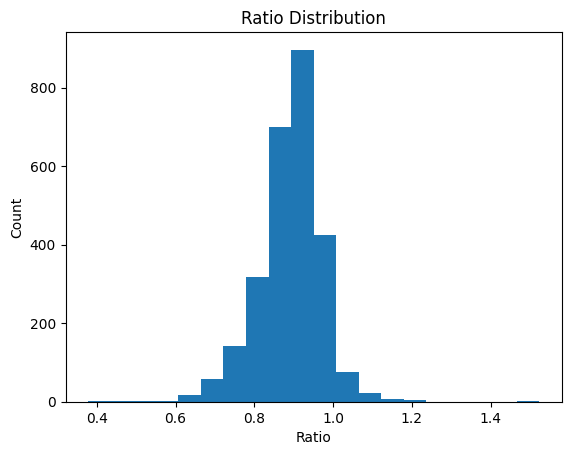

In [13]:
# Ratio Distribution
import matplotlib.pyplot as plt

%matplotlib inline

plt.hist(ratios, bins=20)
plt.title("Ratio Distribution")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.show()

# Clear the Folders

In [14]:
# import os

# dataset_dir = "dataset"

# for folder in os.listdir(dataset_dir):
#     folder_path = os.path.join(dataset_dir, folder)
    
#     if os.path.isdir(folder_path):  # Check if it's a directory
#         for file in os.listdir(folder_path):
#             file_path = os.path.join(folder_path, file)
#             if os.path.isfile(file_path):  # Ensure it's a file before deleting
#                 os.remove(file_path)
#                 print(f"Deleted: {file_path}")

# Loading CommonVoice-VCTK Format (Temporary)

In [15]:
# import os
# import shutil

# data_path = 'D:\CapstoneDatasets\Restructure\data\converted\commonvoice-to-vctk\commonvoice-to-vctk'

# audio_path = os.path.join(data_path, 'wav16_silence_trimmed')
# transcript_path = os.path.join(data_path, 'txt')

# lim = 20

# for speaker_folder in tqdm(os.listdir(audio_path)):
#     speaker_folder_path = os.path.join(audio_path, speaker_folder)
#     if len(os.listdir(speaker_folder_path)) < lim:
#         continue
#     for file in os.listdir(speaker_folder_path)[:lim]:
#         file_path = os.path.join(speaker_folder_path, file)
#         # copy to dataset folder
#         shutil.copy(file_path, REFERENCE_PATH)

# for speaker_folder in tqdm(os.listdir(transcript_path)):
#     speaker_folder_path = os.path.join(transcript_path, speaker_folder)
#     if len(os.listdir(speaker_folder_path)) < lim:
#         continue
#     for file in os.listdir(speaker_folder_path)[:lim]:
#         file_path = os.path.join(speaker_folder_path, file)
#         # copy to dataset folder
#         shutil.copy(file_path, "./dataset/transcripts")

In [16]:
# print(f'Number of reference files: {len(os.listdir(REFERENCE_PATH))}')